# Quantifying Greenwashing Through Corporate Financial Filings

This project aims to shed light on increasingly common practice of greenwashing, where companies exaggerate the good they’re doing for the world via their ESG environmental, social and governance (ESG) disclosures to entice investors, hoodwink customers and generally improve their financial performance. More specifically, it will look at a) what factors correlate to higher third-party ESG scores. It turns out that we can model the variation in ESG score for multiple firms' ESG ratings pretty well looking exclusively at non-ESG company information, such as company size, various financial data, industry and stock price volatility. 


## About the data

### A) Company information

**Financial data** — quarterly (10Q) or annual (10K) reports that public companies are required to file to the U.S. Securities and Exchange Commission (SEC) — for this project is taken from a Kaggle dataset download[^1]. SEC filing data is notoriously difficult to parse since the XBRL formatting of its filings is clunky and hard to navigate, and 10-K reports are long and often larger than 50 MB per file. This dataset extracted key financial information from company 10-Q and 10-K filings of public companies and merged it with stock price history data from Yahoo Finance. The financial information comes from the SEC's bulk data downloads (company facts and submission history) and includes information about assets, debt, taxes and other data points in units of either dollars or stock shares that could give indications of a company's financial health/profile. The Yahoo Finance data is represented in price variance columns which are changes in price over 5, 10, 20, 30 and 60 day periods calculated from the day the form was filed. The data is in 4,624 thousand folders, one for each company.

Additionally, I obtained:
* **Sector data** — a descriptor like "Banks," "Software," or "Chemicals" — by web scraping Yahoo Finance and downloading data from S&P Market Intelligence's Trucost Revenue Sector.
* **Number of employees** and other basic company information from by web scraping Yahoo Finance. 

[^1]: chartma. (2022). SEC Company Facts - All 10-Q & 10-K financial data [Data set](https://www.kaggle.com/datasets/chad116/sec-company-facts-all-10q-10k-financial-data/discussion). Kaggle. https://doi.org/10.34740/KAGGLE/DS/2292262

### B) ESG data

There are several organizations known for their ESG ratings, including MSCI ([Morgan Stanley Capital International](https://www.msci.com/documents/1296102/21901542/ESG-Ratings-Methodology-Exec-Summary.pdf)), [Sustainalytics](https://www.sustainalytics.com/esg-ratings), [Refinitiv](https://www.refinitiv.com/en/sustainable-finance/esg-scores), S&P Global and others. 

* **Sustainalytics**: Getting bulk data for all for all of these ratings is difficult and expensive, but Yahoo Finance — which is a publicly scrapable website — pulls sustainability data from Sustainalytics, financial firm Morningstar's ESG reporting branch. Thus, this project uses a dataset of ESG data from Sustainalytics, numbers that quantify the degree to which ESG issues put a company's business value at risk. The measures combine "exposure," which includes types of risks a particular company faces within its business model and "management," which deals with how the company addresses those risks. It defines its overall score as the amount of risk a company has and does not manage. The data has two parts: The first is scraped from Yahoo Finance and includes a total numeric ESG score; ESG score as a percentile; the E, S and G component scores; and a "controversy" rating based on incidents found in the news. However, Yahoo Finance does not have access to all of Sustainalytics' data (notably for many pharmaceutical companies), so I manually augmented that dataset by searching [Sustainalytics' engine](https://www.sustainalytics.com/esg-rating/) by company ticker — which contains only total ESG score.

* **Refinitiv**: For a point of comparison, because I have access to UPenn Wharton's Data Resources Site (WDRS) through Yale, I submitted a query for a dataset that has ratings from Refinitiv's ESG scores as well, even though it is an outdated formula for scores (last updated in 2020, since WDRS does not have access to Refinitiv's most current methodology). Refinitiv's metrics are similar to Sustainalytics in most ways, but one difference is that it explicitly claims to adjust for industry materiality and company size biases.

# I. Getting and preparing the data

## A. Kaggle 10-K information dataset
### Accessing and saving the data

The Kaggle financial dataset has a different CSV file for each dataset, which is difficult to work with. First, I'm creating a list of csv filenames so I can read them into this notebook and eventually merge them into one dataset. There are 4,624 files — supposedly one for each publicly listed company in the U.S. Although it is not clear how many public companies exist at the moment, a [McKinsey report](https://www.mckinsey.com/capabilities/strategy-and-corporate-finance/our-insights/reports-of-corporates-demise-have-been-greatly-exaggerated) said there were approximately 4,000 public companies in 2020, and a [Statista report](https://www.statista.com/statistics/1277216/nyse-nasdaq-comparison-number-listed-companies/) reported 4,891 public companies listed on the NYSE and NASDAQ exchanges. Thus, 4,624 is a probably number for the total number of public companies, since the number fluctuates due to company entrances, exits, mergers and acquisitions.

In [236]:
import pandas as pd # HIDE THIS LATER
import numpy as np
import json
import time
import os
import collections
from dask import dataframe as df1
import matplotlib.pyplot as plt
import math
import re
import sys
# !pip install statsmodels
import statsmodels.api as sm
np.set_printoptions(threshold=sys.maxsize)
# !pip install dask

To start, we'll look at one of these data files to see what is inside. Here is one for the tech company Sanmina Corporation (ticker SANM). Each of these files has one row per document filed (10-Ks are filed yearly, while 10-Qs are filed quarterly) dating from the company's IPO date, the date at which it needed to start filing to the SEC. 

This file in particular has 51 rows, corresponding to 51 files and 429 columns, which we will explore in more detail shortly.

In [238]:
one_file = pd.read_csv("/Users/phoebeliu/Downloads/SEC_data_kaggle/sec_data_made_useable_w_pricevar/sec_data_made_useable_w_pricevar/CIK0000897723_SANM.csv")
np.shape(one_file)

(51, 429)

In [239]:
one_file.head(5)

,end,filed,form,Name,Ticker,CIK,Currency,PriceVar5,PriceVar10,PriceVar20,...,UnrecognizedTaxBenefitsResultingInNetOperatingLossCarryforward,UnrecognizedTaxBenefitsThatWouldImpactEffectiveTaxRate,ValuationAllowanceDeferredTaxAssetChangeInAmount,ValuationAllowancesAndReservesBalance,ValuationAllowancesAndReservesChargedToCostAndExpense,ValuationAllowancesAndReservesDeductions,WeightedAverageNumberDilutedSharesOutstandingAdjustment,WeightedAverageNumberOfDilutedSharesOutstanding,WeightedAverageNumberOfSharesOutstandingBasic,GainLossOnDispositionOfAssets1
0,2008-09-27,2008-11-24,10-K,Sanmina Corporation,SANM,CIK0000897723,USD,-0.020833,0.041667,0.041667,...,NaN,NaN,NaN,13422000.0,NaN,NaN,NaN,NaN,NaN,NaN
1,2009-10-03,2009-12-01,10-K,Sanmina Corporation,SANM,CIK0000897723,USD,0.171393,0.186190,0.398274,...,NaN,NaN,NaN,16752000.0,3571000.0,-241000.0,NaN,82528000.0,82528000.0,NaN
2,2010-01-02,2010-02-05,10-Q,Sanmina Corporation,SANM,CIK0000897723,USD,0.117231,0.291109,0.376082,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,80575000.0,78615000.0,NaN
3,2010-04-03,2010-04-30,10-Q,Sanmina Corporation,SANM,CIK0000897723,USD,-0.097246,-0.048342,-0.109050,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,82782000.0,79001000.0,NaN
4,2010-07-03,2010-08-05,10-Q,Sanmina Corporation,SANM,CIK0000897723,USD,-0.128878,-0.149562,-0.229912,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,83693000.0,79544000.0,NaN


In the Sanmina Corp. example, there are 51 files ranging from 2008 to 2022, with 37 10-Qs and 14 10-Ks. Other files have similar ranges, with approximately three 10-Qs for every 10-K from either a) when the SEC first started collecting and storing this data publicly and b) when the company in question went public (since private companies don't have to file with the SEC).

In [244]:
print("Date range: {} to {}".format(one_file["filed"][0], one_file["filed"][len(one_file["filed"])-1]))
print("File counts:")
print(one_file["form"].value_counts())

Date range: 2008-11-24 to 2022-02-02
File counts:
10-Q    37
10-K    14
Name: form, dtype: int64


We can also take a look at some of the columns that exist in this data to gain a better understanding of it. There's a lot of financial jargon in the the following list, but a few categories of columns that jump out to me are:
* **AccountsPayableCurrent** and **AccountsReceivableCurrent**, which can be a reflection of financial health in that accounts payable indicates how much a company owes other people, and accounts receivable indicates how much other people owe the company
* **Assets**, which can be current or non-current, with current assets being things like stock, other cash equivalents and inventory
* **EffectiveIncomeTax** and several columns related to taxes and tax benefits can give an indication of company size and income, since the effective income tax rate is calculated by dividing total tax expenses by a company's pre-tax earnings
* **Stock** shares issued, earnings per share and other stock-related columns can give an indication of a company's market value — including the **PriceVariance** column from Yahoo Finance that deals with stock price volatility, which is relevant because some investors gravitate towards stocks with high price volatility for their portfolios.
* One miscellaneous column that stood out to me as the **Goodwill** column, since it represents intangible factors like brand reputation/value, how loyal a customer base is, the company's employee relations or any proprietary company. Goodwill is mainly used in the context of a company's price when another company wants to acquire it, but the factors in it seem like they could be in some ways correlated to ESG metrics (especially the S and G factors)


In [11]:
list(one_file.columns)

['end',
 'filed',
 'form',
 'Name',
 'Ticker',
 'CIK',
 'Currency',
 'PriceVar5',
 'PriceVar10',
 'PriceVar20',
 'PriceVar30',
 'PriceVar60',
 'AccountsAndOtherReceivablesNetCurrent',
 'AccountsPayableCurrent',
 'AccountsReceivableNetCurrent',
 'AccrualForEnvironmentalLossContingenciesIncreaseDecreaseForRevisionInEstimates',
 'AccruedLiabilitiesFairValueDisclosure',
 'AccumulatedDepreciationDepletionAndAmortizationPropertyPlantAndEquipment',
 'AccumulatedOtherComprehensiveIncomeLossCumulativeChangesInNetGainLossFromCashFlowHedgesEffectNetOfTax',
 'AccumulatedOtherComprehensiveIncomeLossDefinedBenefitPensionAndOtherPostretirementPlansNetOfTax',
 'AccumulatedOtherComprehensiveIncomeLossForeignCurrencyTranslationAdjustmentNetOfTax',
 'AccumulatedOtherComprehensiveIncomeLossNetOfTax',
 'AdditionalPaidInCapitalCommonStock',
 'AdditionsToNoncurrentAssets',
 'AdjustmentsNoncashItemsToReconcileNetIncomeLossToCashProvidedByUsedInOperatingActivitiesOther',
 'AdjustmentsRelatedToTaxWithholdingFor

I then concatenated all 4,624 files into one file so I could parse it more easily:

In [12]:
# I concatenated the files and saved it to my disk/uploaded to the project GitHub
# DO NOT RUN THIS CELL — unless you want to get the files yourself — it will take forever

# os.chdir("/Users/phoebeliu/Downloads/SEC_data_kaggle/sec_data_made_useable_w_pricevar/sec_data_made_useable_w_pricevar")
# csv_files = os.listdir()
# df = pd.concat(map(pd.read_csv, csv_files), ignore_index=True)
# np.shape(df)

This dataset is of dimension 170497 x 11690 — one row for each filing (10-K or 10-Q a company made) and one column for each piece of "financial data." There's an unreasonably high number of columns because the names of certain financial markers changed over the years and depending on the type of company and type of form filed.

The next cell saves the file to my local drive so I can access it more quickly in the future.

In [ ]:
df.to_csv("/Users/phoebeliu/Downloads/SEC_Kaggle_Big_Test2.csv") # changed the name so I don't accidentally overwrite the one that exists

Now that I have the data saved on my computer, I can get it by reading it into the notebook. Because it's a big (2GB) file, reading it normally took too long (many hours). I'm using dask to speed up the process by splitting up the data into multiple dataframes so the reading can happen on multiple data "slices" in parallel and thus exponentially faster. The issue with dask is that there's a lot of slicing etc. going on, so it is extremely computationally expensive/takes a long time to index — so once we filter out some of this data, we will convert it back to a normal pandas dataframe.

In [250]:
s_time_dask = time.time()
dask_all = df1.read_csv('/Users/phoebeliu/Downloads/SEC_Kaggle_Big_Test.csv', sample=1000000)
e_time_dask = time.time()
print("Read with dask: ", (e_time_dask-s_time_dask), "seconds")
dask_all.head(10)

Read with dask:  1.6129889488220215 seconds


,Unnamed: 0,end,filed,form,Name,Ticker,CIK,Currency,PriceVar5,PriceVar10,...,ContractsInForceSubjectToParticipationThroughReinsuranceValue,IncomeTaxExpenseBenefitContinuingOperationsAdjustmentOfDeferredTaxAssetLiability.1,OtherComprehensiveIncomeLossFinancialLiabilityFairValueOptionBeforeTaxAfterReclassificationAdjustmentAttributableToParent,IncomeTaxHolidayIncomeTaxBenefitsPerShare.1,RetrospectiveEffectOfChangeInAccountingPrincipleTabularPresentationByFinancialStatementLineItemAmountOfApplicationAdjustment,AssumptionForFairValueOnSecuritizationDateOfInterestsContinuedToBeHeldByTransferorServicingAssetsOrLiabilitiesPrepaymentSpeed,EffectOfChangeInCashFlowProjectionEstimate,EntertainmentLicenseAgreementForProgramMaterialCapitalizedCost,FilmMonetizedOnItsOwnAndFilmMonetizedInFilmGroupAmortizationExpense,ProceedsFromDivestitureOfInterestInJointVenture.1
0,0,2011-04-30,2011-06-16,10-Q,"POINT OF CARE NANO-TECHNOLOGY, INC.",PCNT,CIK0001504239,USD,0.000000,0.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,2011-07-31,2011-11-10,10-K,"POINT OF CARE NANO-TECHNOLOGY, INC.",PCNT,CIK0001504239,USD,0.000000,0.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,2011-10-31,2011-12-20,10-Q,"POINT OF CARE NANO-TECHNOLOGY, INC.",PCNT,CIK0001504239,USD,-0.048387,-0.048387,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3,2012-01-31,2012-03-21,10-Q,"POINT OF CARE NANO-TECHNOLOGY, INC.",PCNT,CIK0001504239,USD,0.000000,0.704546,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,4,2012-04-30,2012-06-14,10-Q,"POINT OF CARE NANO-TECHNOLOGY, INC.",PCNT,CIK0001504239,USD,0.000000,-0.180328,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,5,2012-07-31,2012-11-13,10-K,"POINT OF CARE NANO-TECHNOLOGY, INC.",PCNT,CIK0001504239,USD,-0.166667,-0.166667,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,6,2012-10-31,2012-12-17,10-Q,"POINT OF CARE NANO-TECHNOLOGY, INC.",PCNT,CIK0001504239,USD,0.000000,0.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,7,2013-01-31,2013-03-15,10-Q,"POINT OF CARE NANO-TECHNOLOGY, INC.",PCNT,CIK0001504239,USD,0.000000,0.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,8,2013-04-30,2013-06-14,10-Q,"POINT OF CARE NANO-TECHNOLOGY, INC.",PCNT,CIK0001504239,USD,0.000000,0.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,9,2013-07-31,2013-10-29,10-K,"POINT OF CARE NANO-TECHNOLOGY, INC.",PCNT,CIK0001504239,USD,0.000000,0.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Filtering the data

This is a big dataset. It has too many columns, and most of them are mostly empty (depending on the form and year and even company, the columns are named different things). The goal of this section is to whittle the data into a more manageable size.

Since Sustainalytics' ESG ratings are updated annually, let's look exclusively at 10-K (annual report) data. 

In [252]:
dask_10ks = dask_all[dask_all["form"]=="10-K"]

In [ ]:
# Saving the file to my disk so I can load it again later
# dask_10ks.to_csv("/Users/phoebeliu/Downloads/SEC_Kaggle_10Ks.csv") -- it's saved already so I can deal with this later 

In [253]:
dask_10ks.head(5) # checking that they are all 10-Ks

,Unnamed: 0,end,filed,form,Name,Ticker,CIK,Currency,PriceVar5,PriceVar10,...,ContractsInForceSubjectToParticipationThroughReinsuranceValue,IncomeTaxExpenseBenefitContinuingOperationsAdjustmentOfDeferredTaxAssetLiability.1,OtherComprehensiveIncomeLossFinancialLiabilityFairValueOptionBeforeTaxAfterReclassificationAdjustmentAttributableToParent,IncomeTaxHolidayIncomeTaxBenefitsPerShare.1,RetrospectiveEffectOfChangeInAccountingPrincipleTabularPresentationByFinancialStatementLineItemAmountOfApplicationAdjustment,AssumptionForFairValueOnSecuritizationDateOfInterestsContinuedToBeHeldByTransferorServicingAssetsOrLiabilitiesPrepaymentSpeed,EffectOfChangeInCashFlowProjectionEstimate,EntertainmentLicenseAgreementForProgramMaterialCapitalizedCost,FilmMonetizedOnItsOwnAndFilmMonetizedInFilmGroupAmortizationExpense,ProceedsFromDivestitureOfInterestInJointVenture.1
1,1,2011-07-31,2011-11-10,10-K,"POINT OF CARE NANO-TECHNOLOGY, INC.",PCNT,CIK0001504239,USD,0.000000,0.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,5,2012-07-31,2012-11-13,10-K,"POINT OF CARE NANO-TECHNOLOGY, INC.",PCNT,CIK0001504239,USD,-0.166667,-0.166667,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,9,2013-07-31,2013-10-29,10-K,"POINT OF CARE NANO-TECHNOLOGY, INC.",PCNT,CIK0001504239,USD,0.000000,0.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
13,13,2014-07-31,2014-11-12,10-K,"POINT OF CARE NANO-TECHNOLOGY, INC.",PCNT,CIK0001504239,USD,0.000049,-0.073126,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
17,17,2015-07-31,2015-11-20,10-K,"POINT OF CARE NANO-TECHNOLOGY, INC.",PCNT,CIK0001504239,USD,0.000000,-0.333333,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Now, since we are only using the most recent year of Sustainalytics ratings (historical data is not currently publicly accessible), we will get 10-Ks from just this past year (one per company). First, let's get everything in 2021 and after:

In [254]:
recent_10ks = dask_10ks[dask_10ks["filed"] > "2020-12-31"]

In [17]:
recent_10ks.head(5) # showing that recent_10ks does what it is supposed to 

,Unnamed: 0,end,filed,form,Name,Ticker,CIK,Currency,PriceVar5,PriceVar10,...,ContractsInForceSubjectToParticipationThroughReinsuranceValue,IncomeTaxExpenseBenefitContinuingOperationsAdjustmentOfDeferredTaxAssetLiability.1,OtherComprehensiveIncomeLossFinancialLiabilityFairValueOptionBeforeTaxAfterReclassificationAdjustmentAttributableToParent,IncomeTaxHolidayIncomeTaxBenefitsPerShare.1,RetrospectiveEffectOfChangeInAccountingPrincipleTabularPresentationByFinancialStatementLineItemAmountOfApplicationAdjustment,AssumptionForFairValueOnSecuritizationDateOfInterestsContinuedToBeHeldByTransferorServicingAssetsOrLiabilitiesPrepaymentSpeed,EffectOfChangeInCashFlowProjectionEstimate,EntertainmentLicenseAgreementForProgramMaterialCapitalizedCost,FilmMonetizedOnItsOwnAndFilmMonetizedInFilmGroupAmortizationExpense,ProceedsFromDivestitureOfInterestInJointVenture.1
63,63,2020-12-31,2021-04-13,10-K,"MINIM, INC.",MINM,CIK0001467761,USD,-0.131098,-0.085366,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
120,120,2020-12-31,2021-02-26,10-K,ICU MEDICAL INC/DE,ICUI,CIK0000883984,USD,-0.044723,-0.019422,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
124,124,2021-12-31,2022-02-25,10-K,ICU MEDICAL INC/DE,ICUI,CIK0000883984,USD,0.048832,-0.018476,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
130,130,2020-12-31,2021-02-26,10-K,"CROSSFIRST BANKSHARES, INC.",CFB,CIK0001458412,USD,0.030712,0.124345,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
134,134,2021-12-31,2022-02-28,10-K,"CROSSFIRST BANKSHARES, INC.",CFB,CIK0001458412,USD,0.000000,0.014622,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Now, let's organize this to make sure there's only one report per company, and that it is the most recent one. 

In [255]:
tickerlist = dask_10ks["Ticker"].compute()
nonduplicates = list(set(tickerlist))

### Trying to sort out discrepancies in number of public companies/filings

Getting a list of all the company tickers (what they're listed as on an exchange) returned a list of length 4588 — fewer than the 4624 files. This can be explained by a) some companies merging into one ticker, old companies that no longer exist, etc.

In [256]:
len(nonduplicates)

4588

In [263]:
ciks = dask_10ks["CIK"]
nondup_ciks = list(set(ciks))
nondup_ciks[:10]

['CIK0001371489',
 'CIK0000090498',
 'CIK0001784254',
 'CIK0001326110',
 'CIK0001400732',
 'CIK0001611547',
 'CIK0001378125',
 'CIK0001419051',
 'CIK0000088121',
 'CIK0001745078']

Additionally, as a check, I compiled a list of CIKs (central identification keys — a company identifier which, like tickers, is unique) of all companies that submitted 10-Ks to the SEC within the last year. That list has 7868 items, which is a lot more than both of these ticker lists. That discrepancy can be explained by the fact that many of those 7868 companies are not "real companies" and are rather trusts, SPACs and other acquisition-focused companies, holding companies such as "Strats(SM) Trust for Dominion Resources," "CNH Equipment Trust 2021-B" and "Securities, Series 2005-6." Most of these are "smaller reporting companies" — which means that by the SEC's standards, those companies do not have to report ESG risks. (The SEC does not include those companies in its own bulk data downloads from its [company facts API](https://www.sec.gov/edgar/sec-api-documentation), so we can ignore them for the purposes of this project.

In [258]:
all_ciks = pd.read_csv("/Users/phoebeliu/Downloads/All_Tickers_Researched.csv") 
# This file is the download of tickers and CIKs from all companies that submitted a 10-K to the SEC 
# within the last year, which is also available in the GitHub repo

In [269]:
nondup_ciks = [re.sub("CIK", "", elem) for elem in nondup_ciks]
nondup_ciks = [int(x) for x in nondup_ciks]

[1371489, 90498, 1784254, 1326110, 1400732]


Here, we can see the CIKs few of the 3368 companies that filed 10-Ks with the SEC but are not included in the Kaggle dataset of financial data we are using (examples: Spire Alabama, Hanover House, Kingsway Financial Services). It seems that the Kaggle dataset is not perfect/all-encompassing — since these companyies do have pretty robust "company information" files from the [SEC's Company Facts API](https://www.sec.gov/edgar/sec-api-documentation). There is definitely more exploring to be done here — but I did not have the time/knowledge to parse the XBRL files myself and see if I could get more data. Additionally, around 500 of these 3368 missing files came from a lack of Yahoo Finance Price Variance data.

In [286]:
# gets symmetric difference, wich is 3671 (3368 + 303)
# set_dif = set(all_ciks["CIK"]).symmetric_difference(set(nondup_ciks)) 
# difference = list(set_dif)
# print(len(difference))

left_diff = set(all_ciks["CIK"]).difference(nondup_ciks)
print(len(left_diff))
print(difference[500:510])

# 1072627 is in companyfacts zip
# so is 1073349 and 1075415 and 1075857 and 1077428

# TO DO: TKTK EXPLAIN THAT KAGGLE DATASET IS IMPERFECT

3368
[1069680, 1070050, 1071272, 1072627, 1072842, 1073349, 1074871, 1075415, 1075857, 1077428]


Now, if we go the other way around, there are also some companies included in the Kaggle dataset that did not file with the SEC in the last year — 303 companies.

In [295]:
right_diff = len(set(nondup_ciks).difference(all_ciks))
print(right_diff)
list(set(nondup_ciks).difference(all_ciks))[:10]

4588


[851968,
 917520,
 704532,
 1441816,
 1032220,
 98338,
 1490978,
 1163302,
 1622057,
 1425450]

I did not go through the list exhaustively, but most of the 303 are companies that exited in some way (no longer public or went bankrupt or got acquired). The data is still good, though, so we will keep them in our dataset.

### Making the financial data more manageable (cutting down number of columns)

11,000 columns is too many to model anything that is easily interpretable. First, let's drop all the columns that have no entries (probably old or 10-Q specific things). Our goal is to get this data into a manageable size so we can convert it back to a non-dask dataframe to analyze it more conveniently. This gets us to 7408, which is ... still a lot.

In [58]:
recent_10ks_withoutna = recent_10ks.loc[:, ~recent_10ks.isna().all().compute()]

KeyboardInterrupt: 

Now, let's set a threshold to cut down the number of columns even more. I'm setting an arbitrary threshold of 3000, or about half the companies (since there are 4588 companies represented and each one should have 1-2 10-K reports filed since 2021 began). So these columns would still be majority null/NA. This results in 81 columns, which is much more manageable.

In [ ]:
THRESHOLD = 3000
recent_10ks_fewer_na = recent_10ks_withoutna.loc[:, recent_10ks_withoutna.isna().sum().compute() < THRESHOLD] 

In [ ]:
recent_10ks_fewer_na.head(5)

Now, we can convert this back to a regular dataframe. We will use this dataset later to merge with the ESG rating data.

In [ ]:
final_10ks = recent_10ks_fewer_na.compute()

In [ ]:
# Saving this dataset to my local drive
# final_10ks.to_csv("/Users/phoebeliu/Downloads/Final_10k_document.csv") 

Here is the 10-K dataset we're working with in pandas dataframe form. Notice that the columns still have columns with significan numbers of NAs in them (because this varies company to company as well) – this is something we will need to work around.

In [2]:
final_10k_set = pd.read_csv("/Users/phoebeliu/Documents/SDS_Senior_Project/Final_10k_document.csv")
final_10k_set = final_10k_set.iloc[:,2:]
final_10k_set.iloc[:10]

,end,filed,form,Name,Ticker,CIK,Currency,PriceVar5,PriceVar10,PriceVar20,...,WeightedAverageNumberOfDilutedSharesOutstanding,WeightedAverageNumberOfSharesOutstandingBasic,CashCashEquivalentsRestrictedCashAndRestrictedCashEquivalentsPeriodIncreaseDecreaseIncludingExchangeRateEffect,EffectiveIncomeTaxRateContinuingOperations,LesseeOperatingLeaseLiabilityPaymentsDueAfterYearFive,LesseeOperatingLeaseLiabilityPaymentsDueYearFive,LesseeOperatingLeaseLiabilityPaymentsDueYearFour,OperatingLeasePayments,UnrecognizedTaxBenefits,DeferredIncomeTaxLiabilities
0,2020-12-31,2021-04-13,10-K,"MINIM, INC.",MINM,CIK0001467761,USD,-0.131098,-0.085366,-0.094512,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2020-12-31,2021-02-26,10-K,ICU MEDICAL INC/DE,ICUI,CIK0000883984,USD,-0.044723,-0.019422,-0.016289,...,21591000.0,20907000.0,127427000.0,0.109,15289000.0,5002000.0,8279000.0,10185000.0,18443000.0,NaN
2,2021-12-31,2022-02-25,10-K,ICU MEDICAL INC/DE,ICUI,CIK0000883984,USD,0.048832,-0.018476,-0.017034,...,21781000.0,21206000.0,156730000.0,0.163,10577000.0,4842000.0,5129000.0,11256000.0,21537000.0,NaN
3,2020-12-31,2021-02-26,10-K,"CROSSFIRST BANKSHARES, INC.",CFB,CIK0001458412,USD,0.030712,0.124345,0.053184,...,52548547.0,52070624.0,221490000.0,NaN,NaN,NaN,NaN,NaN,NaN,15222000.0
4,2021-12-31,2022-02-28,10-K,"CROSSFIRST BANKSHARES, INC.",CFB,CIK0001458412,USD,0.000000,0.014622,0.032422,...,52030582.0,51291428.0,73917000.0,NaN,NaN,NaN,NaN,NaN,NaN,11555000.0
5,2020-12-31,2021-02-25,10-K,TIMKENSTEEL CORPORATION,TMST,CIK0001598428,USD,0.201560,0.439532,0.248375,...,45000000.0,45000000.0,75700000.0,-0.020,NaN,NaN,2700000.0,8800000.0,0.0,120600000.0
6,2021-12-31,2022-02-24,10-K,TIMKENSTEEL CORPORATION,TMST,CIK0001598428,USD,0.272485,0.235177,0.548967,...,55000000.0,45900000.0,156800000.0,0.032,NaN,NaN,1100000.0,8200000.0,0.0,100500000.0
7,2020-12-31,2021-03-11,10-K,"FUNKO, INC.",FNKO,CIK0001704711,USD,0.189172,0.255055,0.563601,...,35770013.0,35270795.0,27026000.0,0.172,27614000.0,10028000.0,11279000.0,11600000.0,490000.0,1339000.0
8,2021-12-31,2022-03-03,10-K,"FUNKO, INC.",FNKO,CIK0001704711,USD,-0.026404,-0.019663,-0.038764,...,40610618.0,38392390.0,31302000.0,0.201,20489000.0,9303000.0,10504000.0,14400000.0,0.0,1044000.0
9,2020-12-31,2021-03-11,10-K,"electroCore, Inc.",ECOR,CIK0001560258,USD,0.018692,-0.028037,-0.037383,...,NaN,NaN,-9321854.0,0.047,526560.0,149700.0,146044.0,NaN,NaN,461485.0


Notice that there are still multiple entries per company. Let's make sure that is not the case. We end this part with a dataset containing 4349 rows and 80 columns.

In [3]:
final_10k_set = final_10k_set.drop_duplicates(subset='CIK', keep="last")
print(np.shape(final_10k_set))
final_10k_set[:3]

(4349, 80)


,end,filed,form,Name,Ticker,CIK,Currency,PriceVar5,PriceVar10,PriceVar20,...,WeightedAverageNumberOfDilutedSharesOutstanding,WeightedAverageNumberOfSharesOutstandingBasic,CashCashEquivalentsRestrictedCashAndRestrictedCashEquivalentsPeriodIncreaseDecreaseIncludingExchangeRateEffect,EffectiveIncomeTaxRateContinuingOperations,LesseeOperatingLeaseLiabilityPaymentsDueAfterYearFive,LesseeOperatingLeaseLiabilityPaymentsDueYearFive,LesseeOperatingLeaseLiabilityPaymentsDueYearFour,OperatingLeasePayments,UnrecognizedTaxBenefits,DeferredIncomeTaxLiabilities
0,2020-12-31,2021-04-13,10-K,"MINIM, INC.",MINM,CIK0001467761,USD,-0.131098,-0.085366,-0.094512,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2021-12-31,2022-02-25,10-K,ICU MEDICAL INC/DE,ICUI,CIK0000883984,USD,0.048832,-0.018476,-0.017034,...,21781000.0,21206000.0,156730000.0,0.163,10577000.0,4842000.0,5129000.0,11256000.0,21537000.0,NaN
4,2021-12-31,2022-02-28,10-K,"CROSSFIRST BANKSHARES, INC.",CFB,CIK0001458412,USD,0.000000,0.014622,0.032422,...,52030582.0,51291428.0,73917000.0,NaN,NaN,NaN,NaN,NaN,NaN,11555000.0


## B. Getting ESG scores data and merging it with original financial data

To get a dataset of ESG metrics from Yahoo Finance, I built a list of URLs to Yahoo Finance's "Sustainability" tab for each company, since their URLs all followed the same pattern. Example: [https://finance.yahoo.com/quote/AAPL/sustainability?p=AAPL](https://finance.yahoo.com/quote/AAPL/sustainability?p=AAPL). 

To scrape the site itself, I needed to access the HTML and save it to my computer (so I can recompute it quickly). I tried several approaches (including but not limited to creating a collection runner in the API platform Postman, which ended up crashing my computer several times) but landed on a function through python's multiprocessing library that allowed me to save the 4588 HTML files to my disk.

Then, I used BeautifulSoup to extract the relevant elements (code is in a separate notebook also in the GitHub repository). Finally, I saved the file to my computer. 

Here are the first few lines, with a ticker, total ESG score, percentile, component scores and a rating for controversy based on media/news attention: 

In [4]:
scores_yahoo = pd.read_csv("/Users/phoebeliu/Documents/SDS_Senior_Project/yahoo_sustainalytics_score.csv")
scores_yahoo[:5]

,ticker,total ESG score,percentile,e_score,s_score,g_score,controversy
0,CAH,12,5th percentile,2.0,6.0,5.0,3.0
1,PGR,21,28th percentile,2.0,8.0,11.0,1.0
2,MDLZ,24,39th percentile,9.0,9.0,5.0,3.0
3,DXCM,24,39th percentile,5.0,10.0,8.0,0.0
4,HPQ,11,3rd percentile,0.0,5.0,6.0,2.0


Since the tickers I fed into my scraper are tickers from the SEC Kaggle dataset, there isn't anything in here that does not correspond to a set of SEC filings. 

However, notice that there are only 506 rows:

In [5]:
np.shape(scores_yahoo)

(506, 7)

Why are many of these companies missing SEC data when Sustainalytics claims to have rankings that cover all the main stock indices? I went on Sustainalytics' ESG website and then found that many companies that do not have sustainability data listed on Yahoo Finance. I couldn't figure out why this was, but it tended to be majority pharmaceutical companies and banks/bancorps (companies that control banks but do not actually do banking).

## Merging with the Kaggle financial information dataset

In [6]:
scores_yahoo = scores_yahoo.rename(columns={"ticker": "Ticker"})
merged_kaggle_yahoo = pd.merge(final_10k_set, scores_yahoo, on='Ticker')
print(np.shape(merged_kaggle_yahoo))
merged_kaggle_yahoo[:5]

(506, 86)


,end,filed,form,Name,Ticker,CIK,Currency,PriceVar5,PriceVar10,PriceVar20,...,LesseeOperatingLeaseLiabilityPaymentsDueYearFour,OperatingLeasePayments,UnrecognizedTaxBenefits,DeferredIncomeTaxLiabilities,total ESG score,percentile,e_score,s_score,g_score,controversy
0,2021-12-31,2022-02-22,10-K,SEI INVESTMENTS COMPANY,SEIC,CIK0000350894,USD,0.003254,-0.043501,0.030142,...,5483000.0,10132000.0,1.488600e+07,9.536200e+07,19,22nd percentile,1.0,8.0,10.0,1.0
1,2021-12-31,2022-02-08,10-K,INCYTE CORPORATION,INCY,CIK0000879169,USD,-0.057799,-0.027116,0.015413,...,1418000.0,14300000.0,6.235900e+07,4.037800e+07,24,39th percentile,1.0,16.0,7.0,1.0
2,2021-12-31,2022-02-16,10-K,Amgen Inc.,AMGN,CIK0000318154,USD,-0.007455,0.026633,0.040465,...,49000000.0,190000000.0,3.546000e+09,1.449000e+09,22,32nd percentile,1.0,13.0,8.0,3.0
3,2021-12-31,2022-02-22,10-K,Centene Corporation,CNC,CIK0001071739,USD,0.015861,0.026558,0.066642,...,341000000.0,385000000.0,3.550000e+08,2.792000e+09,21,28th percentile,0.0,13.0,7.0,2.0
4,2021-12-31,2022-02-09,10-K,AMPHENOL CORPORATION,APH,CIK0000820313,USD,-0.039880,-0.079010,-0.063508,...,28800000.0,103200000.0,1.477000e+08,5.857000e+08,22,31st percentile,8.0,5.0,8.0,2.0


This is a small dataset, but let's explore it first and see what insights we can gain for now.

# II. Exploring the data

## A. Exploring distribution of ESG scores and components (response variable)
 
First, we will look at distribution of various ESG metrics within this small dataset. 

### Total ESG score (Yahoo finance-scraped Sustainalytics data)

The histogram is almost bimodal if we increase the number of bins, but it should be fine for our purposes. It's also a bit right-skewed, which we could transform with a sqrt transformation, but the decreased interpetability of our dataset isn't worth the more normal response variable distribution.

Text(0.5, 1.0, 'Untransformed ESG score histogram')

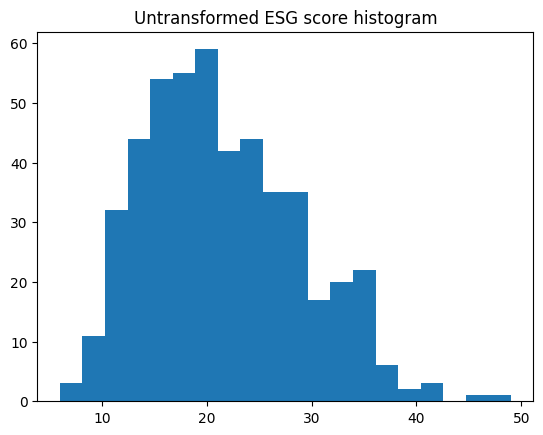

In [297]:
plt.hist(merged_kaggle_yahoo["total ESG score"], bins = 20)
plt.title('Untransformed ESG score histogram')

Text(0.5, 1.0, 'Transformed ESG score histogram')

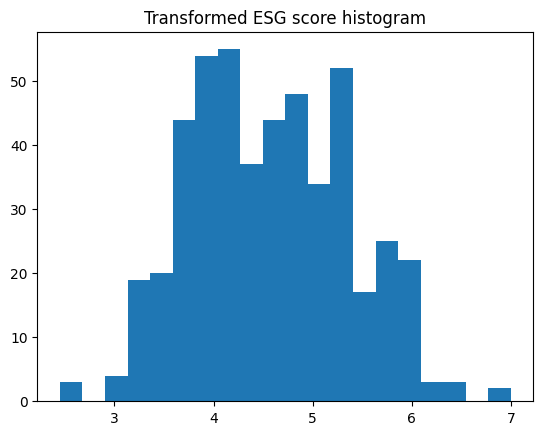

In [298]:
plt.hist(np.sqrt(merged_kaggle_yahoo["total ESG score"]), bins = 20) 
plt.title('Transformed ESG score histogram')

### Looking at the distribution of E, S and G components

We don't really go into the details of these breakdowns in the model, but a chart to visualize what it looks like (all somewhat right-skewed).

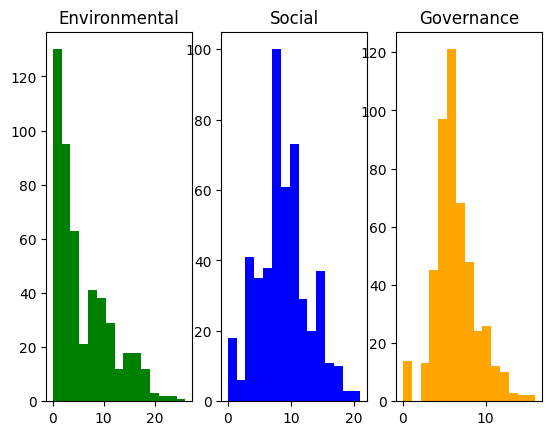

In [299]:
fig = plt.figure()
fig.add_subplot(131)   
plt.title("Environmental")
plt.hist(merged_kaggle_yahoo["e_score"], bins = 15, color = "green", label = "E") # pretty right skewed, should i
fig.add_subplot(132)   
plt.title("Social")
plt.hist(merged_kaggle_yahoo["s_score"], bins = 15, color = "blue") # looks normal
fig.add_subplot(133)   
plt.hist(merged_kaggle_yahoo["g_score"], bins = 15, color = "orange") # looks fairly normal i guess
plt.title("Governance")
plt.show()

### Looking at the distribution of controversy scores

Controversy scores, which reflect how much negative attention a company has gotten in the media about controversies that could relate to ESG, looked pretty standard — most of them are 2 or 3, and there are only 4 values, so we will only come back to this if we want a controversy-specific breakdown. 

Text(0.5, 1.0, 'Controversy score frequency table')

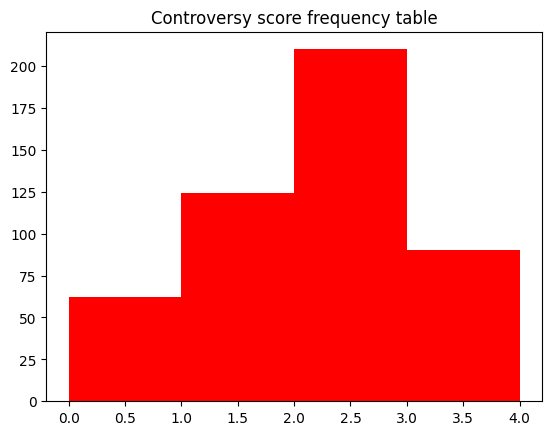

In [300]:
plt.hist(merged_kaggle_yahoo["controversy"], bins = 4, color = "red")
plt.title("Controversy score frequency table")

## The predictor variables: What are they? 

In [301]:
list(merged_kaggle_yahoo.columns)

['end',
 'filed',
 'form',
 'Name',
 'Ticker',
 'CIK',
 'Currency',
 'PriceVar5',
 'PriceVar10',
 'PriceVar20',
 'PriceVar30',
 'PriceVar60',
 'Assets',
 'CashAndCashEquivalentsAtCarryingValue',
 'CommonStockSharesAuthorized',
 'CommonStockSharesIssued',
 'CommonStockValue',
 'DeferredTaxAssetsValuationAllowance',
 'EarningsPerShareBasic',
 'IncomeTaxExpenseBenefit',
 'LiabilitiesAndStockholdersEquity',
 'NetCashProvidedByUsedInFinancingActivities',
 'NetCashProvidedByUsedInInvestingActivities',
 'NetCashProvidedByUsedInOperatingActivities',
 'NetIncomeLoss',
 'OperatingIncomeLoss',
 'RetainedEarningsAccumulatedDeficit',
 'ShareBasedCompensation',
 'StockholdersEquity',
 'AccumulatedOtherComprehensiveIncomeLossNetOfTax',
 'AssetsCurrent',
 'CashCashEquivalentsRestrictedCashAndRestrictedCashEquivalents',
 'ComprehensiveIncomeNetOfTax',
 'CurrentFederalTaxExpenseBenefit',
 'CurrentStateAndLocalTaxExpenseBenefit',
 'DeferredFederalIncomeTaxExpenseBenefit',
 'DeferredIncomeTaxExpenseBenefi

There's a lot going on that we would like to narrow down, and an easy way to do that is by removing columns that are mostly NAs. We remove the columns thath ave more than 100 NAs (1/5 of the dataset, approximately): 

In [305]:
# get na counts for each column 
na_counts = pd.DataFrame(merged_kaggle_yahoo.isna().sum())
na_counts.columns = ["na_count"]
na_counts = na_counts.sort_values(by=["na_count"], ascending=False)

# see which columns have more than 100 NAs 
problem_columns = list(na_counts[na_counts["na_count"] > 100].index)
print(problem_columns)

# drop those columns (the print statement works if the cells are run in the correct order)
merged_kaggle_yahoo = merged_kaggle_yahoo.drop(problem_columns, axis=1)

[]


Now, we have 65 columns left instead of 80. Of particular note are columns mentioned when introducing this dataset that, based on research, could be related pretty strongly to ESG metrics without being explicitly tied to them. All columns are listed below, but of particular interest are:
* Stock price data like price variance
* Metrics that predict company size like Assets and Liabilities
* Goodwill
* Measures related to tax benefits

In [13]:
# see what we have left - 65 columns instead of 80
print(np.shape(merged_kaggle_yahoo))
# see what columns we have left
print(list(merged_kaggle_yahoo.columns))

(506, 65)
['end', 'filed', 'form', 'Name', 'Ticker', 'CIK', 'Currency', 'PriceVar5', 'PriceVar10', 'PriceVar20', 'PriceVar30', 'PriceVar60', 'Assets', 'CashAndCashEquivalentsAtCarryingValue', 'CommonStockSharesAuthorized', 'CommonStockSharesIssued', 'CommonStockValue', 'DeferredTaxAssetsValuationAllowance', 'EarningsPerShareBasic', 'IncomeTaxExpenseBenefit', 'LiabilitiesAndStockholdersEquity', 'NetCashProvidedByUsedInFinancingActivities', 'NetCashProvidedByUsedInInvestingActivities', 'NetCashProvidedByUsedInOperatingActivities', 'NetIncomeLoss', 'OperatingIncomeLoss', 'RetainedEarningsAccumulatedDeficit', 'ShareBasedCompensation', 'StockholdersEquity', 'AccumulatedOtherComprehensiveIncomeLossNetOfTax', 'AssetsCurrent', 'CashCashEquivalentsRestrictedCashAndRestrictedCashEquivalents', 'ComprehensiveIncomeNetOfTax', 'CurrentFederalTaxExpenseBenefit', 'CurrentStateAndLocalTaxExpenseBenefit', 'DeferredFederalIncomeTaxExpenseBenefit', 'DeferredIncomeTaxExpenseBenefit', 'EarningsPerShareDilut

### Correlation plot/matrix to see which variables might be good predictors of ESG score

In [14]:
corr = merged_kaggle_yahoo.corr()

# PLOT THE ACTUAL CORRELATION MATRIX IN SECOND 
# some big correlations are between the pricevars 
# interestingly one of the biggest correlations is between liabilities and assets / bewteen assets and a lot of things
# so it's possible that assets can be a stand in for some of these other vars
# possibly also cash/cashequivalents at carrying value

# also collinarity between the leasing variables

# check on unrecognized tax benefits column as well

# as for total ESG score, highest corrs are price var 60, none of the other variables seem to make that much
# of a difference. should i try to regress anyways???

pd.DataFrame(np.abs(corr["total ESG score"])).sort_values(by=["total ESG score"], ascending=False)

# look into each of these vars, plot/explore/transform as necessary
# then pick variables i want to include in regression (things i am seeing stand out + things i think should)

,total ESG score
total ESG score,1.000000
e_score,0.711075
s_score,0.586396
g_score,0.390157
PriceVar60,0.227683
controversy,0.212325
PriceVar30,0.198209
PropertyPlantAndEquipmentNet,0.196006
InterestPaidNet,0.127573
RetainedEarningsAccumulatedDeficit,0.122795


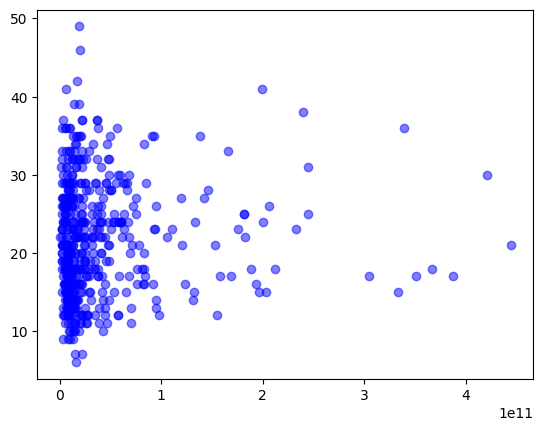

In [15]:
# plot assets and other specific values vs total esg
# maybe transformation
plt.scatter(merged_kaggle_yahoo["Assets"], merged_kaggle_yahoo["total ESG score"], c="blue", alpha=0.5)
plt.show()

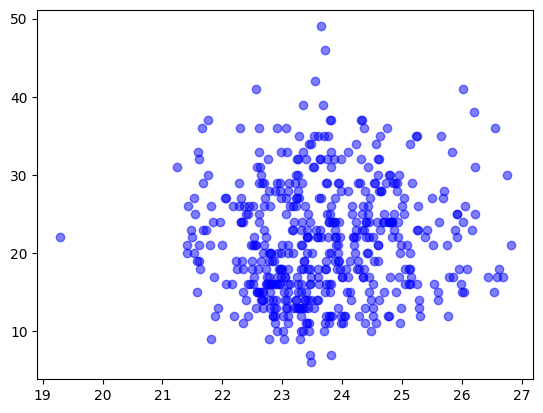

In [16]:
# trying log trans
# try log
plt.scatter(np.log(merged_kaggle_yahoo["Assets"]), merged_kaggle_yahoo["total ESG score"], c="blue", alpha=0.5)
plt.show()
# maybe outlier - look at that as well to explain corrs better

In [17]:
# look for that outlier
np.log(merged_kaggle_yahoo["Assets"]).sort_values(ascending=True)[:10] # maybe remove this one ? 
# let's see what it is 
merged_kaggle_yahoo[32:33]
# cerus corp, has a pretty medium ESG score, guess we can try taking it out and see what happens

# eh we can remove it and see what happens
merged_kaggle_yahoo = merged_kaggle_yahoo.drop(labels=32, axis=0)

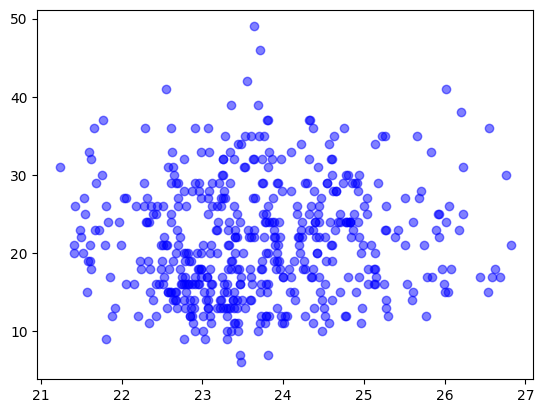

In [18]:
plt.scatter(np.log(merged_kaggle_yahoo["Assets"]), merged_kaggle_yahoo["total ESG score"], c="blue", alpha=0.5)
plt.show()

that looks better
let's move on to another variable 

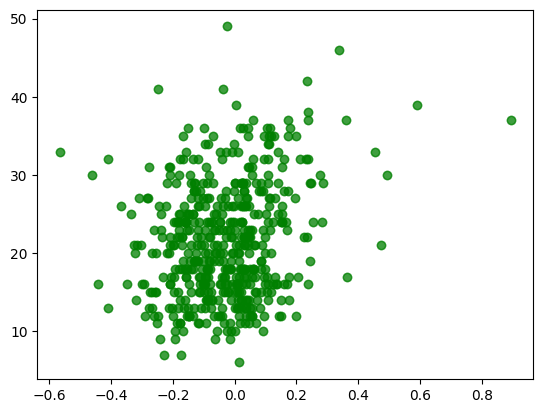

In [19]:
# checking pricevar
plt.scatter(merged_kaggle_yahoo["PriceVar60"], merged_kaggle_yahoo["total ESG score"], c="green", alpha=0.5)
# plt.show()

# remove outliers??
merged_kaggle_yahoo["PriceVar60"].sort_values(ascending=False)[:10]

# remove that last one, index 178
# merged_kaggle_yahoo = merged_kaggle_yahoo.drop(labels=178, axis=0)

# regraph
plt.scatter(merged_kaggle_yahoo["PriceVar60"], merged_kaggle_yahoo["total ESG score"], c="green", alpha=0.5)
plt.show()

# better probably

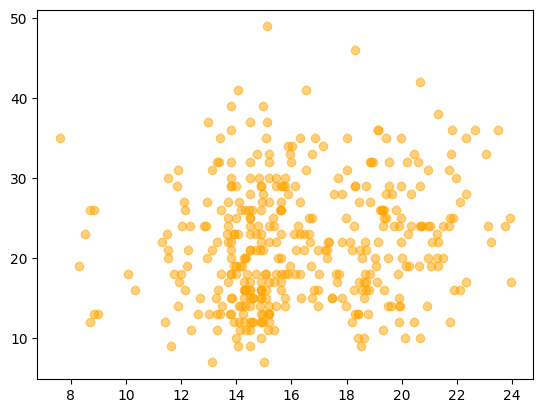

In [20]:
# common stock value???
# plt.scatter(merged_kaggle_yahoo["CommonStockValue"], merged_kaggle_yahoo["total ESG score"], c="orange", alpha=0.5)
# plt.show()

# ok this needs a log transformation 
# plt.scatter(np.log(merged_kaggle_yahoo["CommonStockValue"]+1), merged_kaggle_yahoo["total ESG score"], c="orange", alpha=0.5)
# plt.show() 

# it's better but what are all the zeroes
merged_kaggle_yahoo["CommonStockValue"].sort_values(ascending=True)[:20]

# what would it look like without the zeroes
# 19 of them are zeros 
# merged_kaggle_yahoo["CommonStockValue"].sort_values(ascending=True)[:20]
merged_without_zeroes = merged_kaggle_yahoo[merged_kaggle_yahoo["CommonStockValue"]!=0]
plt.scatter(np.log(merged_without_zeroes["CommonStockValue"]), merged_without_zeroes["total ESG score"], c="orange", alpha=0.5)
plt.show()

merged_kaggle_yahoo = merged_without_zeroes

/Users/phoebeliu/opt/anaconda3/lib/python3.9/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


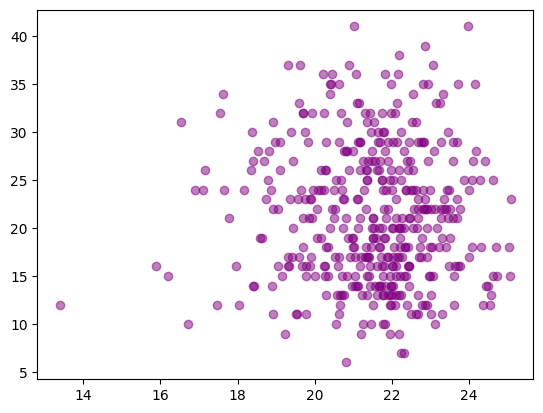

In [21]:
# goodwill
plt.scatter(np.log(merged_kaggle_yahoo["Goodwill"]), merged_kaggle_yahoo["total ESG score"], c="purple", alpha=0.5)
plt.show()

/Users/phoebeliu/opt/anaconda3/lib/python3.9/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


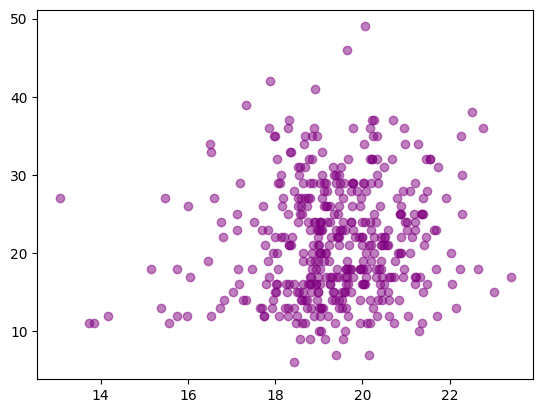

505    13.068965
289    13.726680
201    13.855693
238    14.179460
96     15.160983
124    15.389736
459    15.476972
350    15.561750
267    15.751659
20     15.753965
163    15.980327
196    15.997396
312    16.040783
413    16.461685
16     16.510138
74     16.519553
438    16.523561
150    16.606676
489    16.735926
494    16.770421
Name: IncomeTaxExpenseBenefit, dtype: float64

In [22]:
# IncomeTaxExpenseBenefit
plt.scatter(np.log(merged_kaggle_yahoo["IncomeTaxExpenseBenefit"]+1), merged_kaggle_yahoo["total ESG score"], c="purple", alpha=0.5)
plt.show()

np.log(merged_kaggle_yahoo["IncomeTaxExpenseBenefit"]+1).sort_values(ascending=True)[:20]

In [23]:
# see what companies have the highest and lowest esg scores

# lowest:
merged_kaggle_yahoo.sort_values(by=["total ESG score"], ascending=True)[:20] # ["Name", "Ticker","total ESG score"]

,end,filed,form,Name,Ticker,CIK,Currency,PriceVar5,PriceVar10,PriceVar20,...,LesseeOperatingLeaseLiabilityPaymentsDueYearFive,LesseeOperatingLeaseLiabilityPaymentsDueYearFour,OperatingLeasePayments,UnrecognizedTaxBenefits,total ESG score,percentile,e_score,s_score,g_score,controversy
440,2021-03-31,2021-05-19,10-K,FLEX LTD.,FLEX,CIK0000866374,USD,-0.003367,0.041526,-0.004489,...,70000000.0,87000000.0,1.520000e+08,2.660000e+08,6,1st percentile,0.0,0.0,0.0,1.0
265,2021-12-31,2022-03-01,10-K,"CBRE GROUP, INC.",CBRE,CIK0001138118,USD,-0.095039,-0.085200,-0.061126,...,153623000.0,185185000.0,2.026900e+08,1.919380e+08,7,1st percentile,1.0,2.0,3.0,1.0
195,2021-12-31,2022-02-28,10-K,Jones Lang LaSalle Incorporated,JLL,CIK0001037976,USD,-0.092884,-0.091869,-0.045041,...,90700000.0,110400000.0,1.967000e+08,7.930000e+07,7,1st percentile,1.0,3.0,3.0,1.0
285,2021-10-31,2021-12-17,10-K,"KEYSIGHT TECHNOLOGIES,Â INC.",KEYS,CIK0001601046,USD,0.021450,0.047211,-0.051014,...,NaN,24000000.0,5.300000e+07,2.490000e+08,9,2nd percentile,2.0,2.0,5.0,1.0
388,2021-12-26,2022-02-23,10-K,"Hasbro, Inc.",HAS,CIK0000046080,USD,0.029086,-0.043955,-0.032234,...,18700000.0,24300000.0,5.340000e+07,5.060000e+07,9,2nd percentile,0.1,5.0,4.3,2.0
14,2021-12-31,2022-02-28,10-K,CDW CORP,CDW,CIK0001402057,USD,-0.005161,-0.014264,0.021396,...,24100000.0,27400000.0,3.590000e+07,1.840000e+07,9,2nd percentile,2.0,3.0,3.0,0.0
364,2021-12-31,2022-02-14,10-K,ROBERT HALF INTERNATIONAL INC.,RHI,CIK0000315213,USD,0.006690,0.005937,-0.074594,...,19905000.0,32354000.0,9.125300e+07,1.126400e+07,9,2nd percentile,0.0,6.0,4.0,0.0
324,2021-03-31,2021-05-26,10-K,ELECTRONIC ARTS INC.,EA,CIK0000712515,USD,-0.017987,0.012709,-0.037294,...,27000000.0,34000000.0,8.500000e+07,5.840000e+08,10,3rd percentile,0.0,6.0,5.0,2.0
166,2021-08-31,2021-10-15,10-K,Accenture plc,ACN,CIK0001467373,USD,0.015505,0.042420,0.071353,...,335658000.0,448858000.0,7.531670e+08,1.344460e+09,10,2nd percentile,0.0,5.0,5.0,2.0
63,2021-12-31,2022-02-18,10-K,MANPOWERGROUP INC.,MAN,CIK0000871763,USD,-0.011149,-0.136512,-0.118020,...,31500000.0,41900000.0,1.396000e+08,6.730000e+07,10,2nd percentile,0.0,6.0,4.0,2.0


In [24]:
# highest:
# write about how this seems reasonable bc oil companies (and comment on low ones as well)
merged_kaggle_yahoo.sort_values(by=["total ESG score"], ascending=False)[:20] # ["Name", "Ticker","total ESG score"]

,end,filed,form,Name,Ticker,CIK,Currency,PriceVar5,PriceVar10,PriceVar20,...,LesseeOperatingLeaseLiabilityPaymentsDueYearFive,LesseeOperatingLeaseLiabilityPaymentsDueYearFour,OperatingLeasePayments,UnrecognizedTaxBenefits,total ESG score,percentile,e_score,s_score,g_score,controversy
79,2021-12-31,2022-02-14,10-K,"CONTINENTAL RESOURCES, INC.",CLR,CIK0000732834,USD,-0.080021,-0.033647,-0.004707,...,1258000.0,1295000.0,1.731000e+06,NaN,49,97th percentile,26.0,14.0,10.0,1.0
478,2021-12-31,2022-03-01,10-K,COTERRA ENERGY INC.,CTRA,CIK0000858470,USD,0.108374,-0.050493,0.153120,...,14000000.0,58000000.0,2.300000e+07,7.000000e+06,46,96th percentile,23.0,14.0,9.0,2.0
246,2021-12-31,2022-02-17,10-K,Marathon Oil Corporation,MRO,CIK0000101778,USD,-0.021014,0.045683,0.053906,...,2000000.0,4000000.0,NaN,1.000000e+07,42,91st percentile,24.0,10.0,8.0,2.0
451,2021-12-31,2022-02-11,10-K,GENERAL ELECTRIC COMPANY,GE,CIK0000040545,USD,0.016834,-0.004751,-0.046990,...,262000000.0,353000000.0,8.340000e+08,4.224000e+09,41,90th percentile,14.0,15.0,12.0,3.0
35,2021-05-31,2021-07-26,10-K,RPM INTERNATIONAL INC/DE/,RPM,CIK0000110621,USD,-0.008928,-0.025524,-0.036397,...,29655000.0,34464000.0,7.125700e+07,7.500000e+06,41,91st percentile,19.0,12.0,10.0,1.0
371,2021-09-30,2021-11-16,10-K,TransDigm Group Incorporated,TDG,CIK0001260221,USD,-0.026982,-0.106693,-0.097900,...,10000000.0,13000000.0,2.900000e+07,1.900000e+07,39,87th percentile,13.0,18.0,8.0,2.0
199,2021-12-31,2022-02-16,10-K,ANTERO RESOURCES CORPORATION,AR,CIK0001433270,USD,0.089021,0.203759,0.241840,...,489589000.0,540291000.0,1.352941e+09,0.000000e+00,39,87th percentile,0.0,0.0,0.0,2.0
499,2021-12-31,2022-02-24,10-K,Chevron Corp,CVX,CIK0000093410,USD,0.143048,0.233000,0.229959,...,245000000.0,376000000.0,1.670000e+09,5.288000e+09,38,85th percentile,19.0,9.0,10.0,3.0
273,2021-10-02,2021-11-15,10-K,"TYSON FOODS, INC.",TSN,CIK0000100493,USD,-0.030912,-0.026513,0.009749,...,47000000.0,69000000.0,2.040000e+08,1.520000e+08,37,83rd percentile,14.0,12.0,10.0,4.0
467,2021-03-31,2021-05-21,10-K,EAGLE MATERIALS INC,EXP,CIK0000918646,USD,0.025689,0.018695,-0.057956,...,4170000.0,5651000.0,1.074100e+07,1.284000e+06,37,83rd percentile,22.0,6.0,9.0,0.0


# Some basic inference

Trying to predict total ESG score:

#### TO DO: REDO REGRESSION WITH pandas.stats.api.ols PACKAGE 
what is statistically sig? neg/pos corr? do more here

In [128]:
# !pip3 install -U scikit-learn scipy matplotlib
# maybe do this with the statsmodels API one instead

import sklearn
from sklearn.linear_model import LinearRegression


# there are very few columns without NAs ... what to do here?
# predictors_all = merged_kaggle_yahoo.iloc[:,7:59]
# reg = LinearRegression().fit(predictors_all, merged_kaggle_yahoo["total ESG score"])
merged_kaggle_yahoo.columns

'''
variables to include:
- total ESG score
- PriceVar60 (removed an outlier)
- Assets (log)
- CommonStockValue (removed the zeroes + log)
- Liabilities (not using this — document + share why not using that, expand on why I'm using the other things)
- Goodwill (log)
- IncomeTaxExpenseBenefit (log)
'''

lr_dataset = pd.concat([merged_kaggle_yahoo["PriceVar60"],
                  np.log(merged_kaggle_yahoo["Assets"]+1),
                  np.log(merged_kaggle_yahoo["CommonStockValue"]+1),
                  np.log(merged_kaggle_yahoo["Goodwill"]+1),
                  np.log(merged_kaggle_yahoo["IncomeTaxExpenseBenefit"]+1), 
                   merged_kaggle_yahoo["total ESG score"]], axis=1)

print(np.shape(lr_dataset))
lr_dataset = lr_dataset.dropna() # make note of what dropna does to my sample size 
print(np.shape(lr_dataset))
x = lr_dataset.iloc[:, :5]
y = lr_dataset["total ESG score"]
reg = LinearRegression().fit(x, y)
reg

print(1-reg.score(x, y)) # look for nicer summary to print pandas
print(reg.coef_)
# print(reg.intercept_)

print(np.shape(x))
model = sm.OLS(y, x)
results = model.fit()
print(results.summary())

# only explaining 8% of variation in ESG scores -- maybe try other things ??? 

(486, 6)
(303, 6)
0.9127268619770115
[13.08185063  0.21391264  0.18620186 -0.22892376  0.06443999]
(303, 5)
                                 OLS Regression Results                                
Dep. Variable:        total ESG score   R-squared (uncentered):                   0.912
Model:                            OLS   Adj. R-squared (uncentered):              0.910
Method:                 Least Squares   F-statistic:                              614.6
Date:                Mon, 12 Dec 2022   Prob (F-statistic):                   1.28e-154
Time:                        00:31:41   Log-Likelihood:                         -1009.2
No. Observations:                 303   AIC:                                      2028.
Df Residuals:                     298   BIC:                                      2047.
Df Model:                           5                                                  
Covariance Type:            nonrobust                                                  
            

/Users/phoebeliu/opt/anaconda3/lib/python3.9/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [ ]:
# what variables don't have nas 
# TO DO: Move this up 
na_counts.sort_values(by=["na_count"], ascending=True)[:30]

no_nas = na_counts[na_counts["na_count"]==0]
print(no_nas.index)

na_free_data = merged_kaggle_yahoo[no_nas.index]
np.shape(na_free_data)

na_free_data[:5]
# trying a lin reg on this ???? this has 11 columns ... but the only one that actually means anything is assets
# probably the next best thing is to drop the rows where there are only a few missing 
# and also check that other set i've been manually filling in

In [ ]:
na_counts.sort_values(by=["na_count"], ascending=True)[:30]

# But maybe it's just because we didn't have enough data ...
Let's look with a larger dataset (that I hand-augmented from the Sustainalytics website):

  ticker  total ESG score
0    TSQ             20.5
1    NOG             62.1
2   ROCC             62.0
3    MUX             59.8
4   ESTE             57.8


(array([  4.,  17.,  41., 104., 113., 235., 179., 192., 251., 208., 254.,
        193., 187., 144.,  68.,  58.,  38.,  30.,  17.,   5.,   7.,   3.,
          4.,   2.,   3.]),
 array([ 4.4  ,  6.708,  9.016, 11.324, 13.632, 15.94 , 18.248, 20.556,
        22.864, 25.172, 27.48 , 29.788, 32.096, 34.404, 36.712, 39.02 ,
        41.328, 43.636, 45.944, 48.252, 50.56 , 52.868, 55.176, 57.484,
        59.792, 62.1  ]),
 <BarContainer object of 25 artists>)

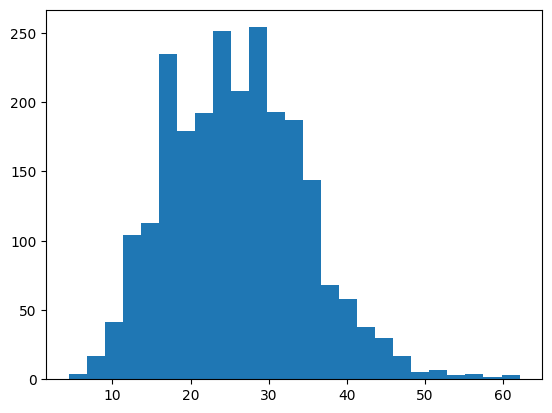

In [27]:
sustainalytics_data = pd.read_csv("/Users/phoebeliu/Documents/SDS_Senior_Project/yahoo_sustainalytics.csv")
sustainalytics_data = sustainalytics_data.iloc[:,:2]
sustainalytics_data = sustainalytics_data.dropna() # 2357, which is a lot more than the 5000
print(sustainalytics_data[:5])
plt.hist(sustainalytics_data["total ESG score"], bins = 25)
# plt.hist(np.sqrt(sustainalytics_data["total ESG score"]), bins = 25) # maybe better but not better enough to 
# make results less interpertable

# comment on relationship between this and the original dataset and note that they are overlapping 

In [28]:
# rename ticker variable to be the same 
# print(merged_kaggle_yahoo[:10])
sustainalytics_data = sustainalytics_data.rename(columns={"ticker": "Ticker"})
sdata_bigger = pd.merge(sustainalytics_data, final_10k_set, on='Ticker')
print(np.shape(sdata_bigger))

# checking corrplot out of curiosity
corr2 = sdata_bigger.corr()
pd.DataFrame(np.abs(corr2["total ESG score"])).sort_values(by=["total ESG score"], ascending=False)[:20]

# TO DO: Insert corrplot here
# here, tax benefits + goodwill seem to be factors (even if not huge)
# assets and liabilities and multiple variations of them are up there as well 
# graph it for fun anyways
# check signs when writing about what all of this means 

(2355, 81)


,total ESG score
total ESG score,1.000000
CurrentStateAndLocalTaxExpenseBenefit,0.130131
Goodwill,0.123212
CurrentIncomeTaxExpenseBenefit,0.123154
OperatingLeaseLiabilityCurrent,0.121842
AssetsCurrent,0.119869
CashAndCashEquivalentsAtCarryingValue,0.117380
LiabilitiesCurrent,0.114048
AccountsReceivableNetCurrent,0.113083
InterestExpense,0.111278


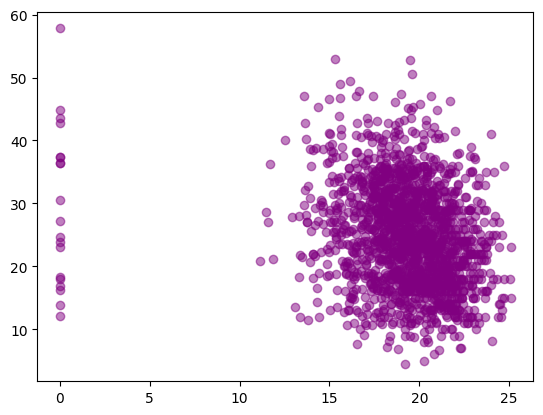

In [129]:
# graphing goodwill bc curious
plt.scatter(np.log(sdata_bigger["Goodwill"]+1), sdata_bigger["total ESG score"], c="purple", alpha=0.5)
plt.show()
# if i removed the zeroes, maybeeeee a weak neg corr but other than that kind of underwhelming 

In [131]:
# linear regression
lr_dataset_2 = pd.concat([sdata_bigger["PriceVar60"],
                  np.log(sdata_bigger["Assets"]+1),
                  np.log(sdata_bigger["CommonStockValue"]+1),
                  np.log(sdata_bigger["Goodwill"]+1),
                  np.log(sdata_bigger["IncomeTaxExpenseBenefit"]+1), 
                   sdata_bigger["total ESG score"]], axis=1)

lr_dataset_2 = lr_dataset_2.dropna()
print(np.shape(lr_dataset_2)) # 1134 x 6 which is better ???? 
x2 = lr_dataset_2.iloc[:, :5]
y2 = lr_dataset_2["total ESG score"]
reg2 = LinearRegression().fit(x2, y2)

# maybe do this with the statsmodels API one instead
print(reg2.score(x2, y2))
print(reg2.coef_)
print(reg2.intercept_)

print(np.shape(x2))
model = sm.OLS(y2, x2)
results2 = model.fit()
print(results2.summary())

# this one's honestly pretty similar just with smaller coefficients but 
# t value of assets is big which is pretty interesting and confirms what we were talking about

# all four of these are significant so yay 
# minus common stock value 

(1134, 6)
0.0768395981084613
[ 6.01006088e+00  6.00723854e-03  1.43601547e-01 -3.87303370e-01
 -4.62389996e-01]
38.42506436680799
(1134, 5)
                                 OLS Regression Results                                
Dep. Variable:        total ESG score   R-squared (uncentered):                   0.903
Model:                            OLS   Adj. R-squared (uncentered):              0.903
Method:                 Least Squares   F-statistic:                              2104.
Date:                Mon, 12 Dec 2022   Prob (F-statistic):                        0.00
Time:                        00:36:37   Log-Likelihood:                         -3977.5
No. Observations:                1134   AIC:                                      7965.
Df Residuals:                    1129   BIC:                                      7990.
Df Model:                           5                                                  
Covariance Type:            nonrobust                               

/Users/phoebeliu/opt/anaconda3/lib/python3.9/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [146]:
lr_dataset_2.iloc[:, [0, 1, 3, 4]]
print(np.shape(lr_dataset_2.iloc[:, [0, 1, 3, 4]].dropna()))

(1134, 4)


In [147]:
# TLDR it's not worse without the stock value -- so just use these four -- and tye're all significat nnow 

print(np.shape(x2))
model = sm.OLS(y2, lr_dataset_2.iloc[:, [0, 1, 3, 4]]) # without stock value 
results2 = model.fit()

# ols(formula="Lottery ~ Literacy + Wealth + Region", data=df)
print(results2.summary())

# .from_formula(formula, data, subset=None, drop_cols=None, *args, **kwargs)¶

(1134, 5)
                                 OLS Regression Results                                
Dep. Variable:        total ESG score   R-squared (uncentered):                   0.903
Model:                            OLS   Adj. R-squared (uncentered):              0.902
Method:                 Least Squares   F-statistic:                              2624.
Date:                Mon, 12 Dec 2022   Prob (F-statistic):                        0.00
Time:                        00:54:51   Log-Likelihood:                         -3979.2
No. Observations:                1134   AIC:                                      7966.
Df Residuals:                    1130   BIC:                                      7986.
Df Model:                           4                                                  
Covariance Type:            nonrobust                                                  
                              coef    std err          t      P>|t|      [0.025      0.975]
------------------

# Still nothing --> additional Yahoo Finance data

If none of the factors from the SEC made a difference, checking additional data scraped from Yahoo Finance to see if anything corr to ESG 

Thinking sector/industry will be interesting for that 
Might be something I can do with description
Couldn't get state/location bc address formatting was so all over the place

In [31]:
yahoo_profile_data = pd.read_csv("/Users/phoebeliu/Documents/SDS_Senior_Project/yahoo_company_profile.csv")
yahoo_profile_data[:10]
np.shape(yahoo_profile_data) # why are there only 637 here ... look into this i guess
# looked into it -- funds/changing indexes/etc (full blurb of notes in other doc)

(640, 5)

In [32]:
# see if sector works for this ??? 
# maybe i do the sector thing where i cluster the things together and make that graph based on a NN (check class code example for this

# sustainalytics_data is the largest set of ESG scores I have as of right now
yahoo_profile_data = yahoo_profile_data.rename(columns={"ticker": "Ticker"})
sdata_yahoo = pd.merge(yahoo_profile_data, sustainalytics_data, on='Ticker')
print(np.shape(sdata_yahoo))

# small data
sdata_yahoo[:10]

(306, 6)


,Ticker,sector,industry,employees,description,total ESG score
0,ONCR,Healthcare,Biotechnology,82,"Oncorus, Inc., a clinical-stage biopharmaceuti...",26.3
1,LHCG,Healthcare,Medical Care Facilities,"29,000","LHC Group, Inc., a health care provider, speci...",21.2
2,WIRE,Industrials,Electrical Equipment & Parts,"1,440",Encore Wire Corporation manufactures and sells...,31.9
3,CAH,Healthcare,Medical Distribution,"45,570","Cardinal Health, Inc. operates as an integrate...",12.0
4,PGR,Financial Services,Insurance—Property & Casualty,"49,077","The Progressive Corporation, an insurance hold...",21.0
5,HOPE,Financial Services,Banks—Regional,"1,539","Hope Bancorp, Inc. operates as the bank holdin...",29.1
6,UNFI,Consumer Defensive,Food Distribution,"30,300","United Natural Foods, Inc., together with its ...",16.4
7,MDLZ,Consumer Defensive,Confectioners,"79,000","Mondelez International, Inc., through its subs...",24.0
8,SKT,Real Estate,REIT—Retail,310,"Tanger Factory Outlet Centers, Inc. (NYSE: SKT...",20.6
9,TPC,Industrials,Engineering & Construction,"7,800","Tutor Perini Corporation, a construction compa...",43.2


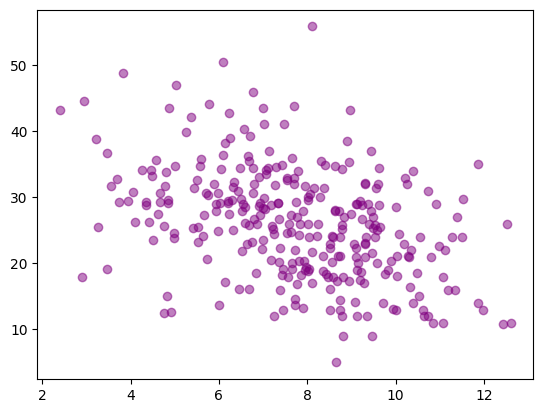

In [45]:
# guess we can look at some stuff -- emp
# plt.scatter(sdata_yahoo["employees"], sdata_yahoo["total ESG score"], c="purple", alpha=0.5)
# plt.show()

sdata_yahoo["employees"] = sdata_yahoo["employees"].replace(',','', regex=True)
sdata_yahoo["employees"] = sdata_yahoo["employees"].astype(float)

plt.scatter(np.log(sdata_yahoo["employees"]+1), sdata_yahoo["total ESG score"], c="purple", alpha=0.5)
plt.show()

# looks like a slight neg corr?

In [46]:
# there's something w/employees - certainly more than anything in the previous dataset 
corr3 = sdata_yahoo.corr()
pd.DataFrame(np.abs(corr3["total ESG score"])).sort_values(by=["total ESG score"], ascending=False)

,total ESG score
total ESG score,1.000000
employees,0.245004


Healthcare                63
Industrials               52
Financial Services        41
Technology                41
Consumer Cyclical         32
Real Estate               22
Energy                    15
Basic Materials           12
Consumer Defensive        10
Communication Services    10
Utilities                  8
Name: sector, dtype: int64


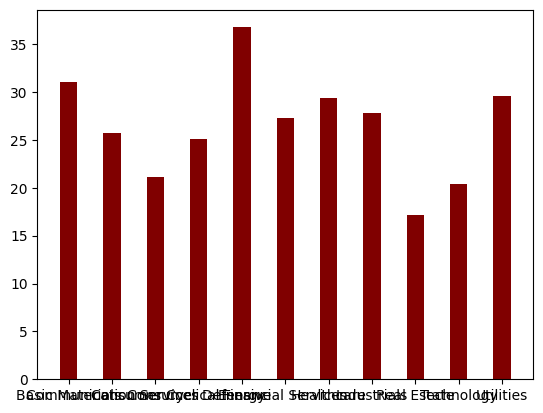

In [88]:
# look at averages by industry - this is how many in each industry (missing a lot of pharmaceutical companies
# for some reason bc i remembered there being a lot of those -- circle back and check on this but that's probably
# sector not industry falling under healthcare )
print(sdata_yahoo['sector'].value_counts())

# just sector and esg score 
sector_esg_df = sdata_yahoo.iloc[:,[1, 5]]   # df.loc[:, ['C', 'D', 'E']]
by_industry = sector_esg_df.groupby(['sector']).mean() # means are diff but there are also diff numbers of things in the 
# categories
# make a dictionary
test_dict = sector_esg_df.groupby(['sector']).mean().apply(list).to_dict()
sector_esg_dict = test_dict["total ESG score"]
plt.bar(sector_esg_dict.keys(), sector_esg_dict.values(), color ='maroon',
    width = 0.4)
plt.show()

# need to fix the labels on this though

# TO DO: maybe scatter plot? try to make it clearer? look at average, min, max
# summary: average, min, max, ?? table where each row is a sector 
# .summarize ??? 

Biotechnology                 38
Banks—Regional                25
Software—Application          12
Software—Infrastructure       10
Medical Devices                9
                              ..
REIT—Healthcare Facilities     1
Drug Manufacturers—General     1
Insurance—Reinsurance          1
Real Estate Services           1
Beverages—Non-Alcoholic        1
Name: industry, Length: 95, dtype: int64
{'Basic Materials': 31.099999999999998, 'Communication Services': 25.68, 'Consumer Cyclical': 21.109375, 'Consumer Defensive': 25.05, 'Energy': 36.766666666666666, 'Financial Services': 27.273170731707317, 'Healthcare': 29.374603174603173, 'Industrials': 27.801923076923078, 'Real Estate': 17.12272727272727, 'Technology': 20.414634146341463, 'Utilities': 29.6}


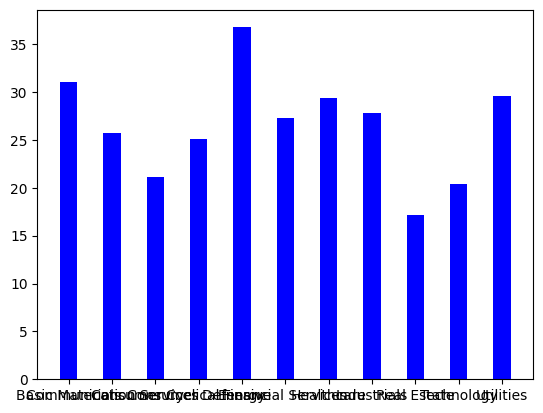

In [106]:
# same with industry 
# probably delete this? TO DO: come back and check 
print(sdata_yahoo['industry'].value_counts())
# just industry and esg score 
industry_esg_df = sdata_yahoo.iloc[:,[1, 5]]  # double check this column
by_industry = industry_esg_df.groupby(['sector']).mean() # means are diff but there are also diff numbers of things in the 
# categories
# make a dictionary
test_dict = industry_esg_df.groupby(['sector']).mean().apply(list).to_dict()
industry_esg_dict = test_dict["total ESG score"]
print(industry_esg_dict) # confirming what we previously said by looking at companies -- those in the energy sector have the highest 
plt.bar(industry_esg_dict.keys(), industry_esg_dict.values(), color ='blue',
    width = 0.4)
plt.show()

In [121]:
# one hot encoding for categorical data 
lr_dataset_3 = pd.concat([np.log(sdata_yahoo["employees"]+1),
                  sdata_yahoo["sector"], sdata_yahoo["industry"], sdata_yahoo["total ESG score"]], axis=1)

print(np.shape(lr_dataset_3))
lr_dataset_3 = lr_dataset_3.dropna()
print(np.shape(lr_dataset_3)) # dropna goes from 306 to 298 lol 
x3 = lr_dataset_3.iloc[:, :3]
x3_cat = pd.get_dummies(data=x3, drop_first=True)
y3 = lr_dataset_3["total ESG score"]
reg3 = LinearRegression().fit(x3_cat, y3)

# maybe do this with the statsmodels API one instead
print(reg3.score(x3_cat, y3)) # actually pretty good - which is expected bc of industry so think about this more
# print(reg3.coef_)
# print(reg3.intercept_)

model = sm.OLS(y3, x3_cat)
results = model.fit()
print(results.summary())


# TO DO: Check which is the omitted one (maybe want this to be the biggest one)
# Group small sectors into "other"

# mixed effects regression ? 

(306, 4)
(298, 4)
0.7182285859931563
                            OLS Regression Results                            
Dep. Variable:        total ESG score   R-squared:                       0.719
Model:                            OLS   Adj. R-squared:                  0.593
Method:                 Least Squares   F-statistic:                     5.694
Date:                Mon, 12 Dec 2022   Prob (F-statistic):           2.60e-25
Time:                        00:02:34   Log-Likelihood:                -867.86
No. Observations:                 298   AIC:                             1922.
Df Residuals:                     205   BIC:                             2266.
Df Model:                          92                                         
Covariance Type:            nonrobust                                         
                                                      coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------

## This isn't a lot of industry data though .. let's look at more

This data is from the TRBC Sector Classification

In [155]:
sp_industry = pd.read_csv("/Users/phoebeliu/Documents/SDS_Senior_Project/SandP_WithIndustry.csv")
np.shape(sp_industry) # 1921 rows by 15 columns
print(sp_industry.columns) # these are the columns, but we're mostly just interested in "simpleindustry" and "ticker"
industry_data = sp_industry.iloc[:, [9, 14]]
print(industry_data[:10])
print(np.shape(industry_data)) # 1921 which is a lot more than like 600 or whatever so let's go with it?

Index(['institutionid', 'sectorperiodid', 'periodenddate', 'tcprimarysectorid',
       'primarysectorname', 'tcsectorid', 'tcsectorname', 'di_324389_text',
       'companyid', 'ticker', 'status', 'companytype', 'country',
       'yearfounded', 'simpleindustry'],
      dtype='object')
  ticker simpleindustry
0   BOKF          Banks
1   BOKF          Banks
2   BOKF          Banks
3   AROW          Banks
4   CATY          Banks
5    CBU          Banks
6    CBU          Banks
7    CBU          Banks
8   CHCO          Banks
9    CPF          Banks
(1921, 2)


In [209]:
# print(industry_data["simpleindustry"].value_counts()[:10]) # there are 64 industries here
# print(industry_data["simpleindustry"].value_counts()[50:])
# collect everything that's below 5 into one thing 
industry_data["simpleindustry"] = industry_data["simpleindustry"].str.replace("Distributors", "Other")
industry_data["simpleindustry"] = industry_data["simpleindustry"].str.replace("Gas Utilities", "Other")
industry_data["simpleindustry"] = industry_data["simpleindustry"].str.replace("Tobacco", "Other")
industry_data["simpleindustry"] = industry_data["simpleindustry"].str.replace("Containers and Packaging", "Other")
industry_data["simpleindustry"] = industry_data["simpleindustry"].str.replace("Automobiles", "Other")
industry_data["simpleindustry"] = industry_data["simpleindustry"].str.replace("Multiline Retail", "Other")
industry_data["simpleindustry"] = industry_data["simpleindustry"].str.replace("Water Utilities", "Other")
industry_data["simpleindustry"] = industry_data["simpleindustry"].str.replace("Paper and Forest Products", "Other")
industry_data["simpleindustry"] = industry_data["simpleindustry"].str.replace("Water Utilities", "Other")
industry_data["simpleindustry"] = industry_data["simpleindustry"].str.replace("Airlines", "Other")
industry_data["simpleindustry"] = industry_data["simpleindustry"].str.replace("Marine", "Other")
industry_data["simpleindustry"] = industry_data["simpleindustry"].str.replace("Transportation Infrastructure", "Other")

# final value counts
print(industry_data["simpleindustry"].value_counts()) # need to remove duplicates from thsi as well?


Banks                                               218
Biotechnology                                       129
Specialty Retail                                     86
Software                                             83
Machinery                                            72
Health Care Equipment and Supplies                   71
Health Care Providers and Services                   56
Hotels, Restaurants and Leisure                      53
Equity Real Estate Investment Trusts (REITs)         49
Electronic Equipment, Instruments and Components     48
Food Products                                        46
Household Durables                                   46
Media                                                40
Capital Markets                                      40
Insurance                                            40
Pharmaceuticals                                      39
Thrifts and Mortgage Finance                         39
Diversified Consumer Services                   

In [210]:
# merge it 
industry_data = industry_data.rename(columns={"ticker": "Ticker"})
merged_with_industry = pd.merge(industry_data, sdata_bigger, on='Ticker') 
merged_with_industry = merged_with_industry.drop_duplicates()
merged_with_industry[:10]

,Ticker,simpleindustry,total ESG score,end,filed,form,Name,CIK,Currency,PriceVar5,...,WeightedAverageNumberOfDilutedSharesOutstanding,WeightedAverageNumberOfSharesOutstandingBasic,CashCashEquivalentsRestrictedCashAndRestrictedCashEquivalentsPeriodIncreaseDecreaseIncludingExchangeRateEffect,EffectiveIncomeTaxRateContinuingOperations,LesseeOperatingLeaseLiabilityPaymentsDueAfterYearFive,LesseeOperatingLeaseLiabilityPaymentsDueYearFive,LesseeOperatingLeaseLiabilityPaymentsDueYearFour,OperatingLeasePayments,UnrecognizedTaxBenefits,DeferredIncomeTaxLiabilities
0,BOKF,Banks,23.0,2021-12-31,2022-02-23,10-K,BOK FINANCIAL CORP,CIK0000875357,USD,-0.029227,...,68594322.0,68591920.0,1.656837e+09,0.226,130000000.0,22600000.0,23600000.0,25300000.0,21092000.0,170899000.0
3,AROW,Banks,32.0,2021-12-31,2022-03-11,10-K,ARROW FINANCIAL CORPORATION,CIK0000717538,USD,-0.001176,...,16073000.0,16018000.0,7.670500e+07,0.226,NaN,NaN,NaN,794000.0,0.0,19449000.0
4,CATY,Banks,31.5,2021-12-31,2022-03-01,10-K,Cathay General Bancorp,CIK0000861842,USD,-0.043871,...,78570638.0,78268369.0,1.028626e+09,0.219,3248000.0,2639000.0,3431000.0,9900000.0,NaN,21328000.0
5,CBU,Banks,28.9,2021-12-31,2022-03-01,10-K,"COMMUNITY BANK SYSTEM, INC.",CIK0000723188,USD,-0.001268,...,54400000.0,53977000.0,NaN,0.214,5846000.0,3062000.0,4401000.0,8203000.0,0.0,89593000.0
8,CHCO,Banks,30.9,2021-12-31,2022-02-24,10-K,CITY HOLDING COMPANY,CIK0000726854,USD,0.038271,...,30463000.0,30407000.0,1.059720e+08,0.208,NaN,NaN,NaN,NaN,1846000.0,15551000.0
9,CPF,Banks,22.9,2021-12-31,2022-02-23,10-K,Central Pacific Financial Corp.,CIK0000701347,USD,-0.041120,...,28257323.0,28003744.0,2.248400e+08,NaN,NaN,NaN,NaN,6533000.0,NaN,16958000.0
10,CVBF,Banks,29.7,2021-12-31,2022-03-01,10-K,CVB FINANCIAL CORP.,CIK0000354647,USD,0.007857,...,135382000.0,135165000.0,NaN,0.286,1438000.0,2101000.0,3112000.0,7081000.0,0.0,28737000.0
11,FBNC,Banks,34.5,2021-12-31,2022-03-01,10-K,FIRST BANCORP,CIK0000811589,USD,-0.029847,...,30027785.0,29876151.0,9.387200e+07,NaN,22499000.0,1685000.0,1707000.0,1814000.0,NaN,19411000.0
12,FFBC,Banks,30.7,2021-12-31,2022-02-18,10-K,FIRST FINANCIAL BANCORP.,CIK0000708955,USD,-0.012229,...,95897385.0,95034690.0,-1.102300e+07,NaN,50311000.0,6269000.0,6673000.0,6860000.0,2386000.0,93010000.0
13,FLIC,Banks,29.4,2021-12-31,2022-03-11,10-K,THE FIRST OF LONG ISLAND CORPORATION,CIK0000740663,USD,-0.021583,...,23762983.0,23655635.0,NaN,0.192,2239000.0,1503000.0,1793000.0,2475000.0,0.0,11820000.0


In [211]:
# one final model bringing everything togetber

In [212]:
# build a table that's industry vs mean esg score
simpleindustry_esgscore = merged_with_industry.iloc[:,[1, 2]]
simpleindustry_esgscore.groupby(['simpleindustry']).mean().sort_values(by="total ESG score", ascending=False) # this is a dataframe
# this makes sense and again confirms what was happening earlier -- oil/chemicals have the greatest impact

,total ESG score
simpleindustry,
"Oil, Gas and Consumable Fuels",47.525000
Chemicals,37.085714
Construction Materials,37.000000
Food Products,34.664706
Metals and Mining,34.350000
Construction and Engineering,34.346667
Beverages,33.400000
Pharmaceuticals,32.927778
Personal Products,32.200000


## Let's see if we can get a better model combining industry with the other stuff
look at what the dummy variable is
holding industry as mixed effect?

In [215]:
lr_dataset_4 = pd.concat([merged_with_industry["PriceVar60"],
                  np.log(merged_with_industry["Assets"]+1),
                 #  np.log(merged_with_industry["CommonStockValue"]+1), # not significant here
                  np.log(merged_with_industry["Goodwill"]+1),
                  np.log(merged_with_industry["IncomeTaxExpenseBenefit"]+1), 
                   merged_with_industry["simpleindustry"],
                   merged_with_industry["total ESG score"]], axis=1)


print(np.shape(lr_dataset_4))
lr_dataset_4 = lr_dataset_4.dropna()
print(np.shape(lr_dataset_4)) # 1134 x 6 which is better ???? 
x4 = lr_dataset_4.iloc[:, :5]
x4_cat = pd.get_dummies(data=x4, drop_first=True)
y4 = lr_dataset_4["total ESG score"]

model = sm.OLS(y4, x4_cat)
results4 = model.fit()
print(results4.summary())

# this one has 649 datapoints not great but will do
# write some stuff about the coefficients and how when you add industry to the model 
# goodwill becomes a bit less significant, assets becomes more important relatively

(1018, 6)
(649, 6)
                                 OLS Regression Results                                
Dep. Variable:        total ESG score   R-squared (uncentered):                   0.945
Model:                            OLS   Adj. R-squared (uncentered):              0.940
Method:                 Least Squares   F-statistic:                              182.8
Date:                Mon, 12 Dec 2022   Prob (F-statistic):                        0.00
Time:                        03:38:37   Log-Likelihood:                         -2105.0
No. Observations:                 649   AIC:                                      4322.
Df Residuals:                     593   BIC:                                      4573.
Df Model:                          56                                                  
Covariance Type:            nonrobust                                                  
                                                                      coef    std err          t     

/Users/phoebeliu/opt/anaconda3/lib/python3.9/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [214]:
lr_dataset_4[:20]

,PriceVar60,Assets,Goodwill,IncomeTaxExpenseBenefit,simpleindustry,total ESG score
0,-0.178653,24.640265,20.767043,19.007217,Banks,23.0
3,-0.032931,22.116524,16.900764,16.492895,Banks,32.0
4,-0.143519,23.762380,19.734912,18.240824,Banks,31.5
5,-0.091614,23.467497,20.499008,17.760078,Banks,28.9
8,0.020307,22.515641,18.505941,17.194837,Banks,30.9
10,0.057180,23.488559,20.313351,18.259655,Banks,29.7
11,-0.138660,23.075488,19.713387,17.021301,Banks,34.5
12,-0.209467,23.516217,20.724015,17.392704,Banks,30.7
14,-0.149914,22.271836,17.158372,16.483988,Banks,27.8
15,-0.054761,23.739947,20.708225,17.390185,Banks,27.8


## Want to try it with another ESG rating dataset 
this one is refinitiv not sustainalytics

In [198]:
refinitiv_data = pd.read_csv("/Users/phoebeliu/Documents/SDS_Senior_Project/WDRS_Data_Query_All.csv")
print(np.shape(refinitiv_data))
refinitiv_data[:5]

# for the purposess of this project we are only interested in score and cscore -- cscore takes into account 
# controversies -- not 100% sure if that's what we want yet -- let's see 

(7780, 18)


,OrgID,FisYear,Score,CScore,ControversiesScore,ResourceUseScore,EmissionsScore,InnovationScore,WorkforceScore,HumanRightsScore,CommunityScore,ProductRespScore,ManagementScore,ShareholdersScore,CSRStrategyScore,OrgName,PrimExchg,tick
0,10295,2019,0.677259,0.677259,1.0,0.722477,0.845041,0.0,0.784644,0.551948,0.983146,0.973568,0.770983,0.396882,0.903974,Imperial Oil Ltd,TOR,IMO
1,10295,2021,0.630801,0.630801,1.0,0.598814,0.808244,0.0,0.602990,0.490099,0.971761,0.970260,0.806352,0.431352,0.897183,Imperial Oil Ltd,TOR,IMO
2,10295,2017,0.628874,0.628874,1.0,0.687500,0.881395,0.0,0.635827,0.467290,0.879921,0.951613,0.732595,0.460443,0.781659,Imperial Oil Ltd,TOR,IMO
3,10295,2022,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Imperial Oil Ltd,TOR,IMO
4,10295,2020,0.642132,0.642132,1.0,0.626033,0.832075,0.0,0.608014,0.465789,0.970383,0.970703,0.870798,0.404412,0.882090,Imperial Oil Ltd,TOR,IMO


In [227]:
refinitiv_data = refinitiv_data.rename(columns={"tick": "Ticker"})
refinitiv_merge = pd.merge(refinitiv_data, merged_with_industry, on='Ticker')
refinitiv_merge[:10]

#model = sm.OLS(y4, x4_cat)
#results4 = model.fit()
#print(results4.summary())

lr_dataset_5 = pd.concat([refinitiv_merge["PriceVar60"],
                  np.log(refinitiv_merge["Assets"]+1),
                 #  np.log(merged_with_industry["CommonStockValue"]+1), # not significant here
                  np.log(refinitiv_merge["Goodwill"]+1),
                  np.log(refinitiv_merge["IncomeTaxExpenseBenefit"]+1), 
                   refinitiv_merge["simpleindustry"],
                   refinitiv_merge["Score"]], axis=1)


print(np.shape(lr_dataset_5))
lr_dataset_5 = lr_dataset_5.dropna()
print(np.shape(lr_dataset_5))
x5 = lr_dataset_5.iloc[:, :5]
x5_cat = pd.get_dummies(data=x5, drop_first=True)
y5 = lr_dataset_5["Score"]

model = sm.OLS(y5, x5_cat)
results5 = model.fit()
print(results5.summary())

# this one is pretty good too -- better than the sustainalytics dataste actually .911 R squared
# big f stat too 
# score vs cscore it's like .912 vs .911, so both are pretty good


(2910, 6)
(1700, 6)
                                 OLS Regression Results                                
Dep. Variable:                  Score   R-squared (uncentered):                   0.911
Model:                            OLS   Adj. R-squared (uncentered):              0.908
Method:                 Least Squares   F-statistic:                              318.2
Date:                Mon, 12 Dec 2022   Prob (F-statistic):                        0.00
Time:                        03:45:03   Log-Likelihood:                          1140.7
No. Observations:                1700   AIC:                                     -2175.
Df Residuals:                    1647   BIC:                                     -1887.
Df Model:                          53                                                  
Covariance Type:            nonrobust                                                  
                                                                      coef    std err          t    

/Users/phoebeliu/opt/anaconda3/lib/python3.9/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
